In [ ]:

import os, sys
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, REPO_ROOT)


from scripts.data_acquisition.main import load_dataset as load_raw_dataset
from scripts.preprocessing.main import preprocess_dataset, save_outputs

from scripts.feature_selection.main import (
    load_processed,
    select_via_lasso,
    select_via_forest,
    select_via_mutual_info,
    hybrid_selection,
    save_selected)

from scripts.training.main import available_specs, run_model_search

raw_df = load_raw_dataset(
    input_path=os.path.join(REPO_ROOT, "data.csv"),
    gdrive_id="1tYfm5wJXRHZGa5h3fsRA7tnyFUlWESpa",)

print(raw_df.shape)
raw_df.head()

                  date        p     T    Tpot  Tdew    rh  VPmax  VPact  \
0  2020-01-01 00:10:00  1008.89  0.71  273.18 -1.33  86.1   6.43   5.54   
1  2020-01-01 00:20:00  1008.76  0.75  273.22 -1.44  85.2   6.45   5.49   
2  2020-01-01 00:30:00  1008.66  0.73  273.21 -1.48  85.1   6.44   5.48   
3  2020-01-01 00:40:00  1008.64  0.37  272.86 -1.64  86.3   6.27   5.41   
4  2020-01-01 00:50:00  1008.61  0.33  272.82 -1.50  87.4   6.26   5.47   

   VPdef    sh  ...      rho    wv  max. wv     wd  rain  raining  SWDR  PAR  \
0   0.89  3.42  ...  1280.62  1.02     1.60  224.3   0.0      0.0   0.0  0.0   
1   0.95  3.39  ...  1280.33  0.43     0.84  206.8   0.0      0.0   0.0  0.0   
2   0.96  3.39  ...  1280.29  0.61     1.48  197.1   0.0      0.0   0.0  0.0   
3   0.86  3.35  ...  1281.97  1.11     1.48  206.4   0.0      0.0   0.0  0.0   
4   0.79  3.38  ...  1282.08  0.49     1.40  209.6   0.0      0.0   0.0  0.0   

   max. PAR   Tlog  
0       0.0  11.45  
1       0.0  11.51  
2    

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, zscore, probplot, mannwhitneyu, f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use("ggplot")

# Tipos y parsing de fechas
df = raw_df.copy()
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
datetime_cols = df.select_dtypes(include=[np.datetime64]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in datetime_cols]
cat_cols = [c for c in cat_cols if c not in datetime_cols]
target_col = "Tlog" if "Tlog" in df.columns else None

print("Num cols:", len(numeric_cols), "Cat cols:", len(cat_cols), "Datetime:", datetime_cols)


Num cols: 20 Cat cols: 0 Datetime: ['date']


In [3]:
desc = df[numeric_cols].describe().T
desc["skew"] = df[numeric_cols].skew()
desc["kurtosis"] = df[numeric_cols].kurtosis()
display(desc.head())

normtests = []
for col in numeric_cols:
    vals = df[col].dropna()
    if len(vals) > 5000:
        vals = vals.sample(5000, random_state=1)
    W, p = shapiro(vals)
    normtests.append((col, W, p))
norm_df = pd.DataFrame(normtests, columns=["variable", "W", "p_value"])
display(norm_df.head())


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
p,52696.0,989.989233,9.207149,955.58,984.8000,990.92,995.93,1020.07,-0.402410,0.707013
T,52696.0,10.818241,7.468671,-6.44,4.5900,10.23,16.18,34.80,0.325698,-0.540933
Tpot,52696.0,284.796938,7.616995,266.19,278.5500,284.32,290.26,309.13,0.272049,-0.517768
Tdew,52696.0,5.409105,5.956722,-13.81,0.7775,5.26,9.70,20.50,0.036904,-0.473798
rh,52696.0,72.487133,19.230260,21.16,58.8200,75.40,87.90,100.00,-0.448010,-0.747121


,variable,W,p_value
0,p,0.984400,4.439706e-23
1,T,0.981069,2.531781e-25
2,Tpot,0.986284,1.198673e-21
3,Tdew,0.990428,6.583015e-18
4,rh,0.956672,3.538410e-36


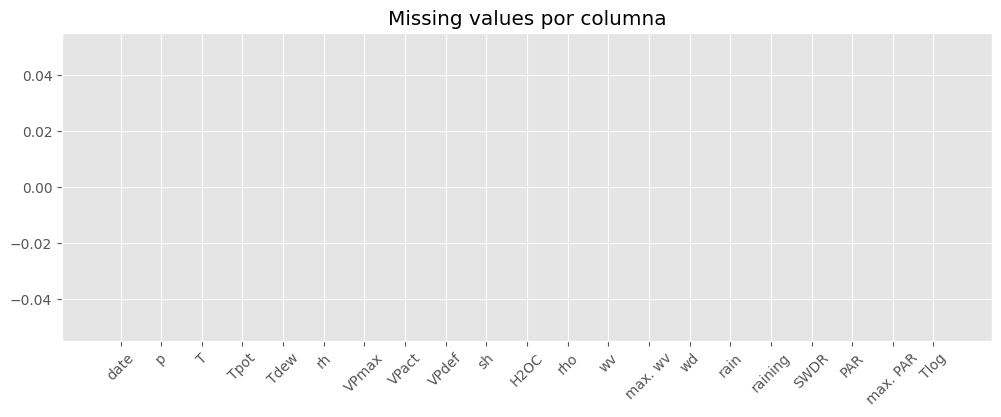

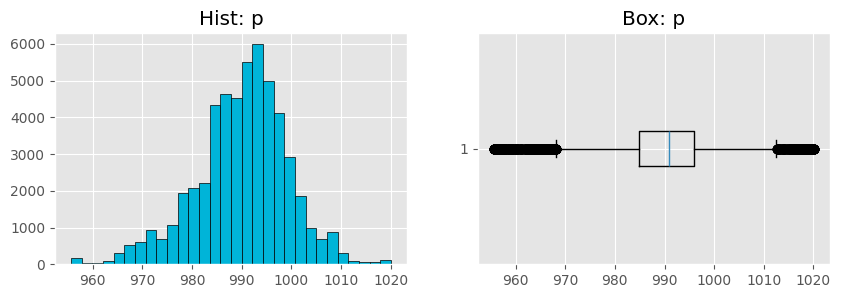

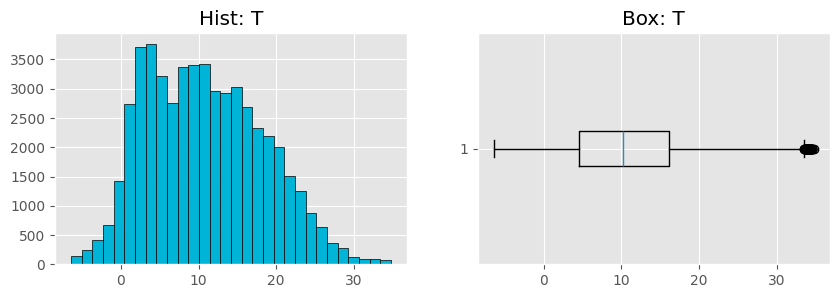

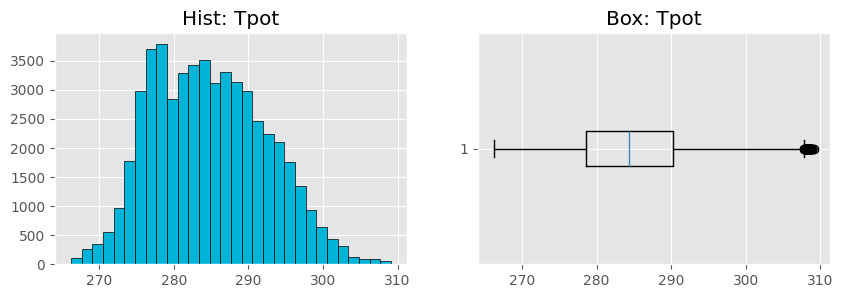

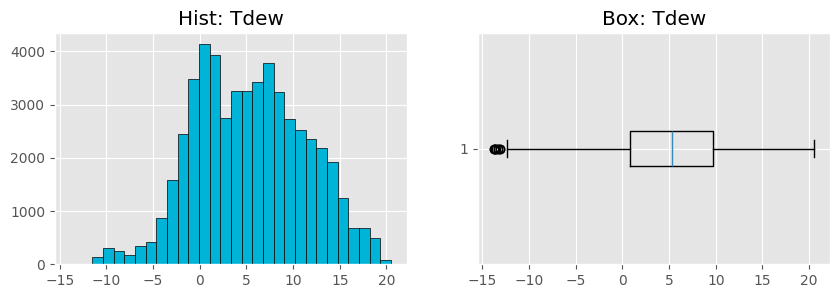

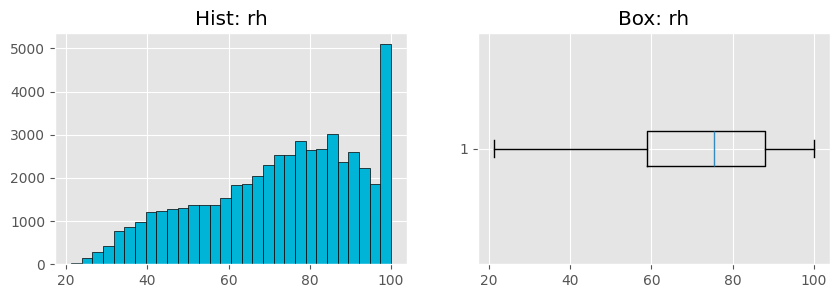

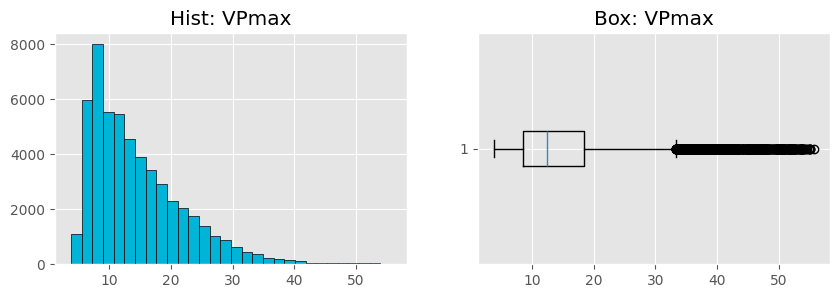

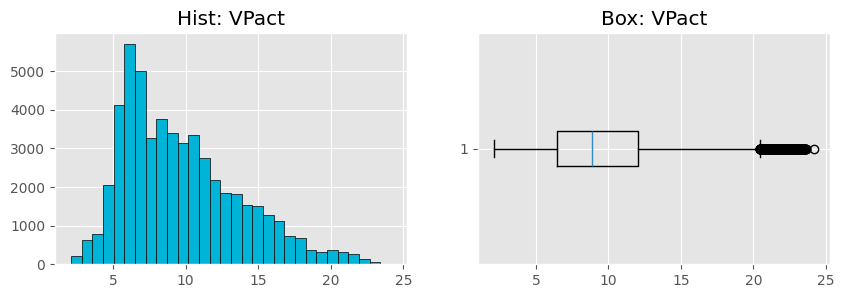

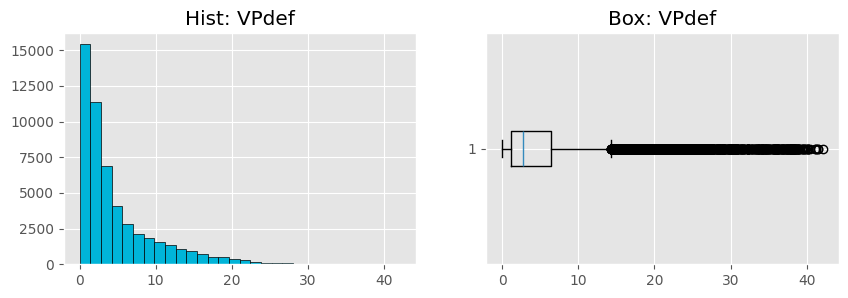

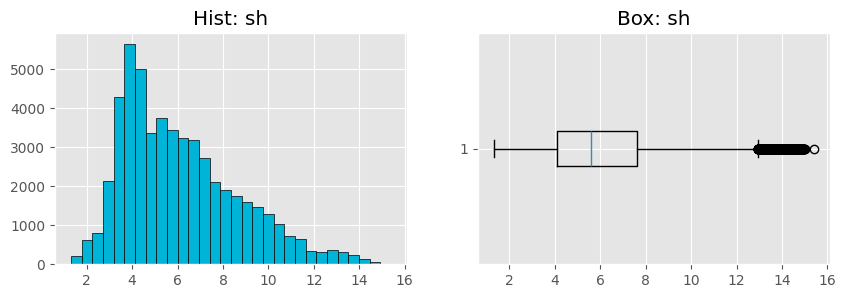

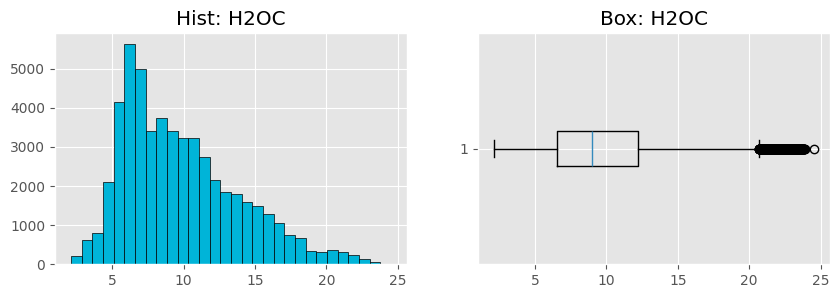

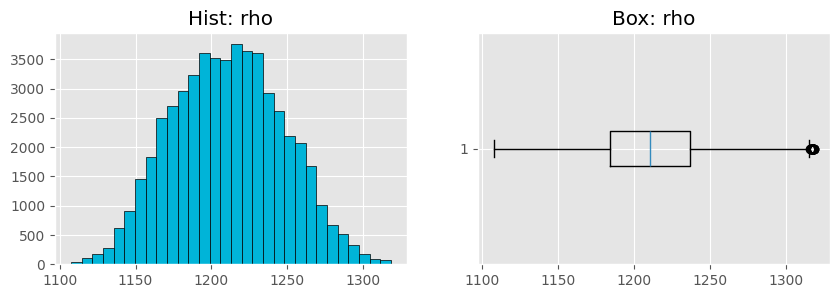

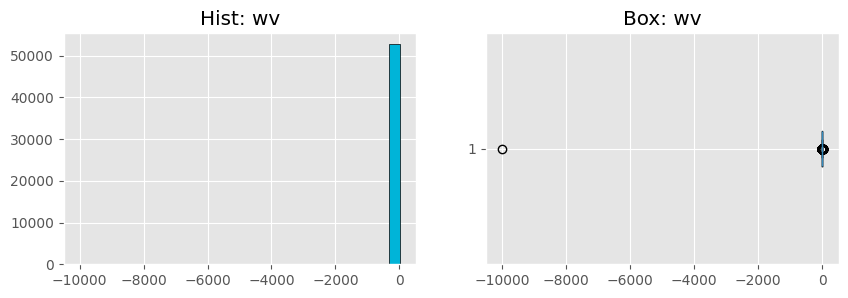

In [4]:

fig, ax = plt.subplots(figsize=(12, 4))
missing = df.isna().sum()
ax.bar(missing.index, missing.values)
ax.set_title("Missing values por columna")
ax.tick_params(axis="x", rotation=45)
plt.show()

# Hist y box
for col in numeric_cols[:12]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].hist(df[col].dropna(), bins=30, color="#00b4d8", edgecolor="black")
    axes[0].set_title(f"Hist: {col}")
    axes[1].boxplot(df[col].dropna(), vert=False)
    axes[1].set_title(f"Box: {col}")
    plt.show()


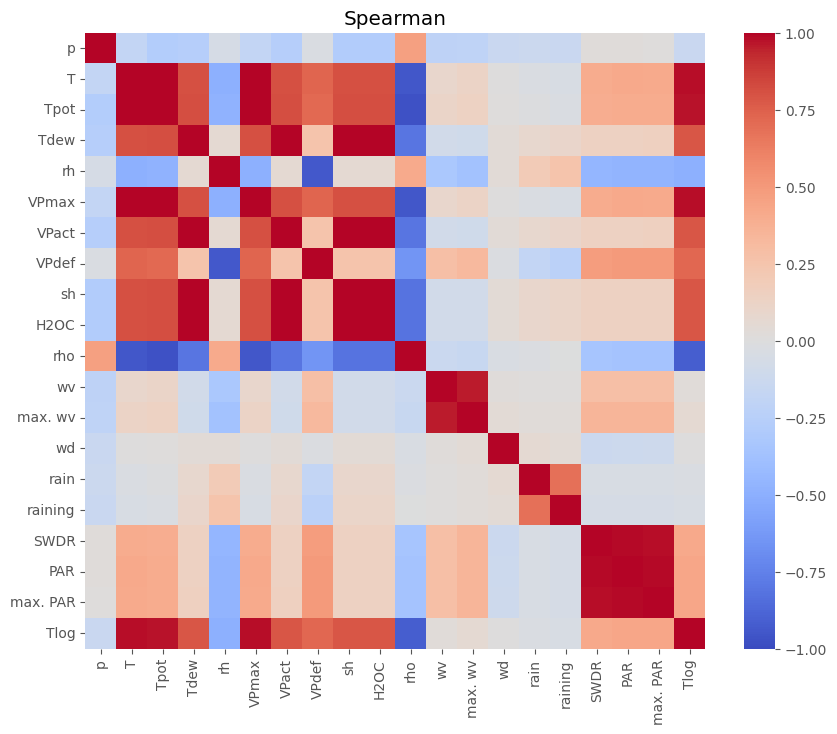

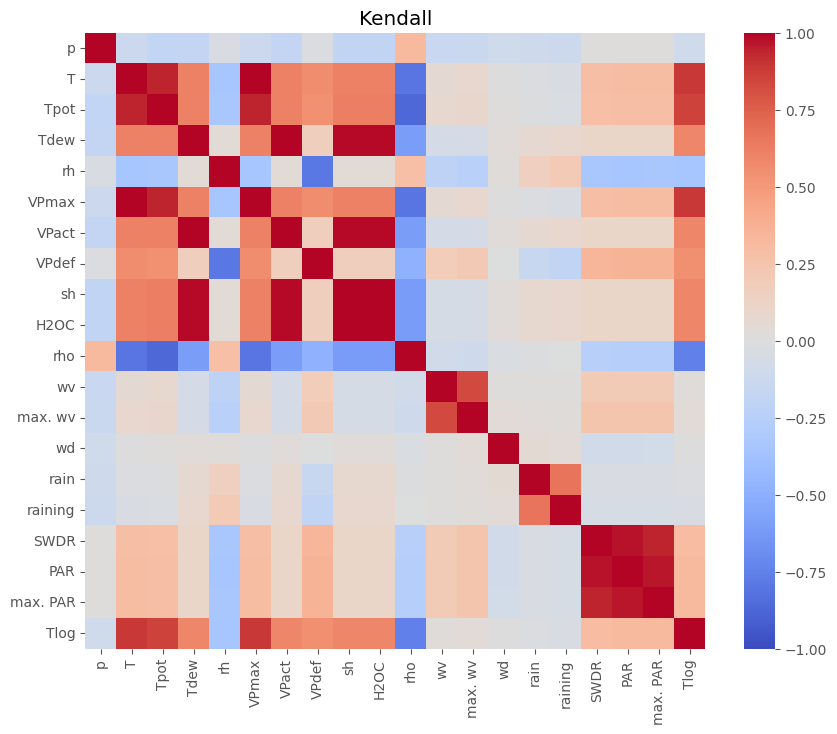

In [5]:
corr_spear = df[numeric_cols].corr(method="spearman")
corr_kend = df[numeric_cols].corr(method="kendall")

def plot_heatmap(matrix, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matrix, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title(title)
    plt.show()

plot_heatmap(corr_spear, "Spearman")
plot_heatmap(corr_kend, "Kendall")


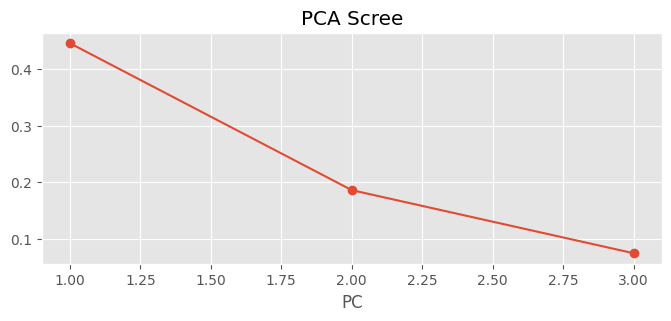

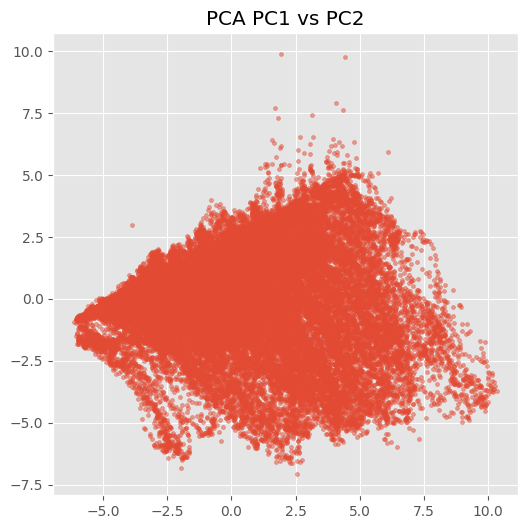

In [6]:
if len(numeric_cols) >= 2:
    clean = df[numeric_cols].dropna()
    Xs = StandardScaler().fit_transform(clean)
    pca = PCA(n_components=3).fit(Xs)
    Xp = pca.transform(Xs)

    plt.figure(figsize=(8, 3))
    plt.plot(range(1, 4), pca.explained_variance_ratio_, marker="o")
    plt.title("PCA Scree"); plt.xlabel("PC"); plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(Xp[:, 0], Xp[:, 1], s=8, alpha=0.5)
    plt.title("PCA PC1 vs PC2"); plt.show()


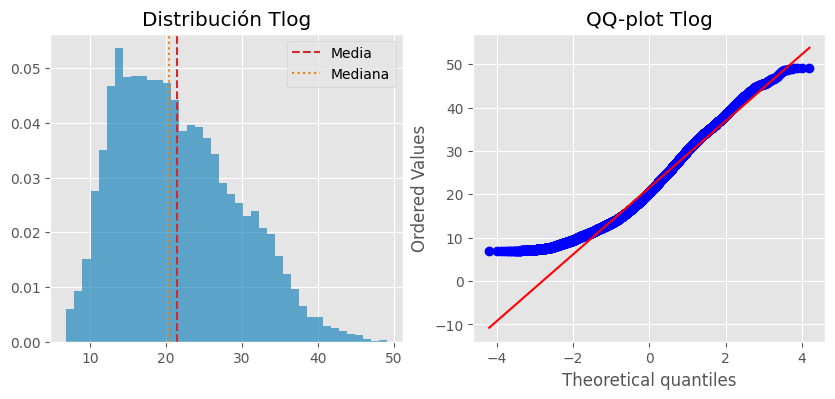

Top correlaciones con target:


VPmax    0.983058
T        0.983058
Tpot     0.973882
rho     -0.920399
VPact    0.783097
Tdew     0.783095
sh       0.781552
H2OC     0.781552
VPdef    0.724888
rh      -0.497805
Name: Tlog, dtype: float64

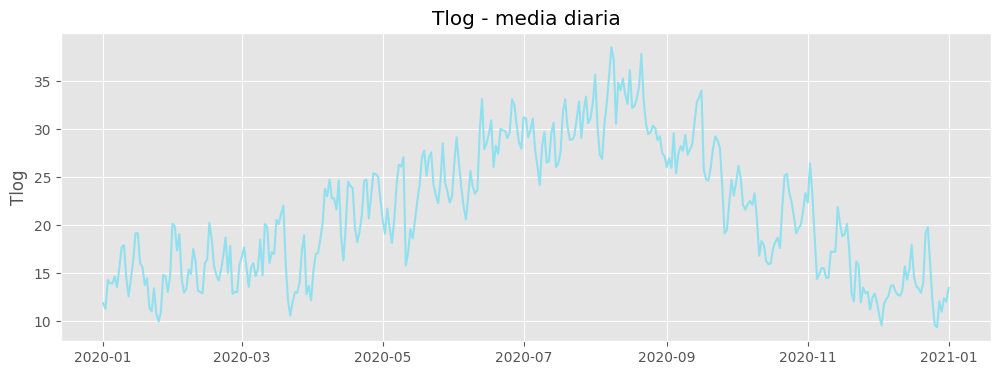

Mann-Whitney lluvia vs seco: stat=74304568.00, p=4.31e-26
ANOVA por estación: F=17444.66, p=0


In [ ]:
if target_col:
    vals = df[target_col].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(vals, bins=40, density=True, color="#0077b6", alpha=0.6)
    axes[0].axvline(vals.mean(), color="#d62828", linestyle="--", label="Media")
    axes[0].axvline(vals.median(), color="#f77f00", linestyle=":", label="Mediana")
    axes[0].legend(); axes[0].set_title(f"Distribución {target_col}")

    probplot(vals, dist="norm", plot=axes[1])
    axes[1].set_title(f"QQ-plot {target_col}")
    plt.show()

    corr_df = df[numeric_cols + [target_col]].corr(method="spearman")

    corr_series = corr_df[target_col]
    if isinstance(corr_series, pd.DataFrame):
        corr_series = corr_series.iloc[:, 0]  

    corr_series = corr_series.drop(labels=[target_col], errors="ignore")
    order = corr_series.abs().sort_values(ascending=False).index
    corr_target = corr_series.loc[order]

    print("Top correlaciones con target:")
    display(corr_target.head(10))

    if "date" in df.columns:
        ts = df.set_index("date")[target_col].sort_index().dropna()
        daily = ts.resample("D").mean()
        plt.figure(figsize=(12, 4))
        plt.plot(daily.index, daily.values, color="#90e0ef")
        plt.title(f"{target_col} - media diaria"); plt.ylabel(target_col)
        plt.show()

    if "raining" in df.columns:
        rainy = df.loc[df["raining"] > 0, target_col].dropna()
        dry = df.loc[df["raining"] == 0, target_col].dropna()
        if len(rainy) > 10 and len(dry) > 10:
            t_stat, t_p = mannwhitneyu(rainy, dry, alternative="two-sided")
            print(f"Mann-Whitney lluvia vs seco: stat={t_stat:.2f}, p={t_p:.3g}")

    if "date" in df.columns:
        season_map = {12:"Inv",1:"Inv",2:"Inv",3:"Prim",4:"Prim",5:"Prim",6:"Ver",7:"Ver",8:"Ver",9:"Oto",10:"Oto",11:"Oto"}
        df["season"] = df["date"].dt.month.map(season_map)
        groups = [g[target_col].dropna() for _, g in df.groupby("season")]
        if len(groups) >= 2 and all(len(g) > 20 for g in groups):
            f_stat, f_p = f_oneway(*groups)
            print(f"ANOVA por estación: F={f_stat:.2f}, p={f_p:.3g}")



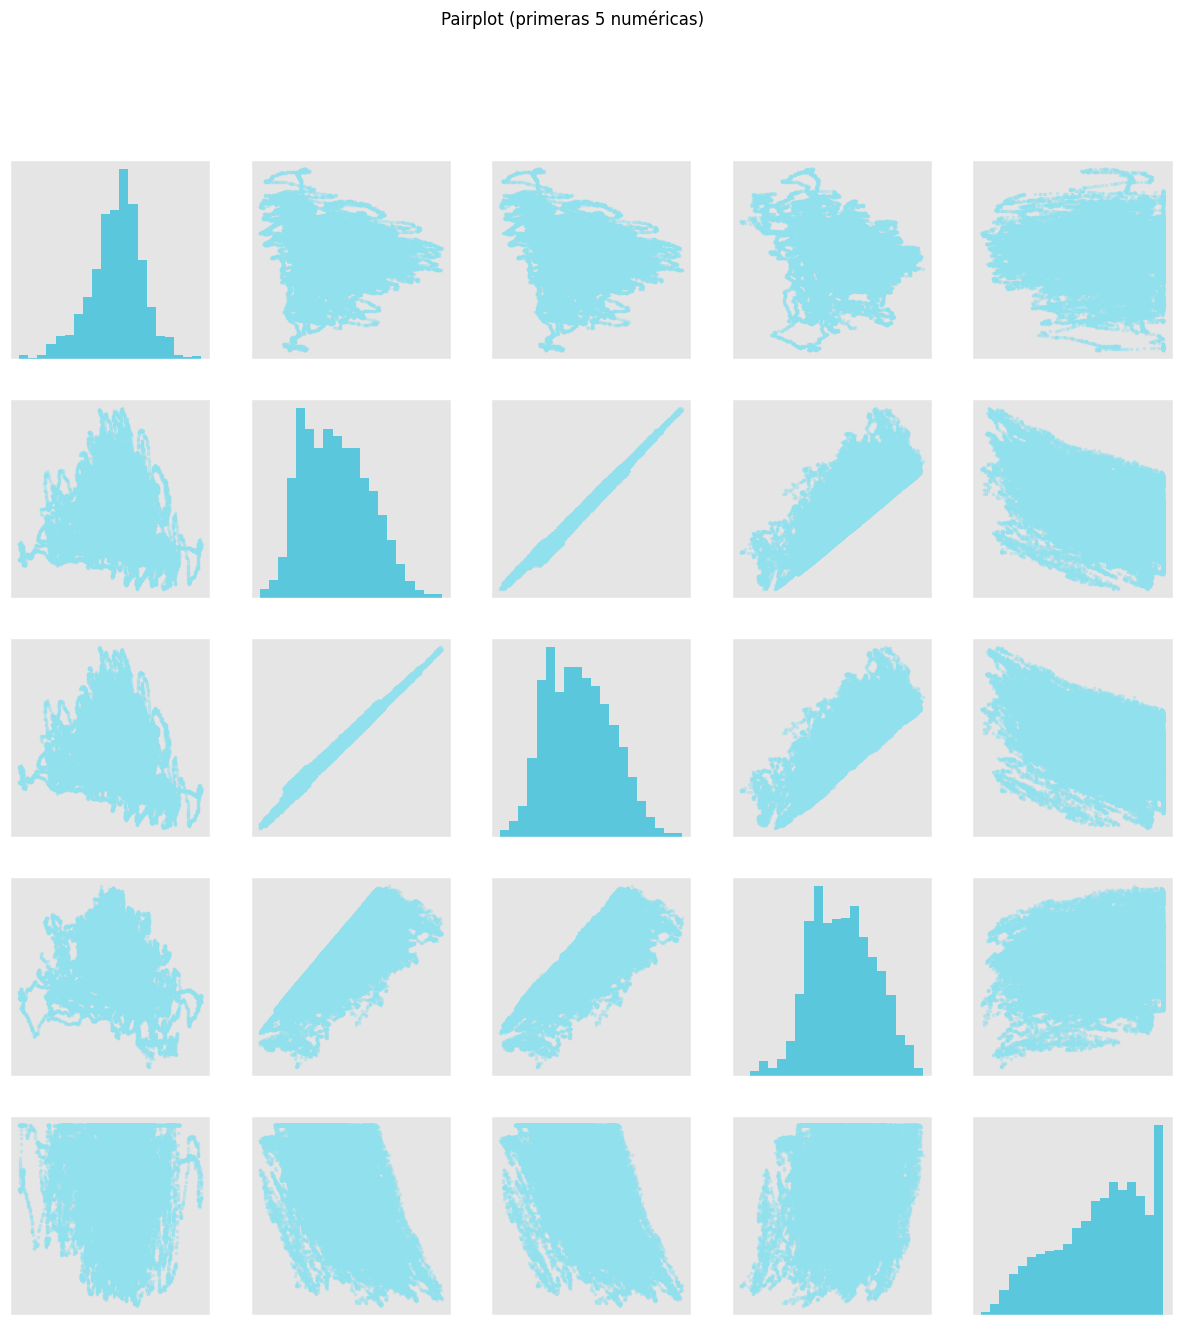

In [12]:
pairs = numeric_cols[:5]
k = len(pairs)
fig, axes = plt.subplots(k, k, figsize=(3*k, 3*k))
for i, xi in enumerate(pairs):
    for j, yi in enumerate(pairs):
        ax = axes[i, j]
        if i == j:
            ax.hist(df[xi].dropna(), bins=20, color="#00b4d8", alpha=0.6)
        else:
            ax.scatter(df[yi], df[xi], s=4, alpha=0.4, color="#90e0ef")
        ax.set_xticks([]); ax.set_yticks([])
plt.suptitle("Pairplot (primeras 5 numéricas)")
plt.show()


In [10]:
z_outliers = (np.abs(zscore(df[numeric_cols], nan_policy="omit")) > 3).sum(axis=0)
print("Outliers (|z|>3) por variable:")
display(pd.DataFrame({"variable": numeric_cols, "z_outliers": z_outliers}).head())


Outliers (|z|>3) por variable:


,variable,z_outliers
0,p,380
1,T,75
2,Tpot,59
3,Tdew,9
4,rh,0
